## Description:

    Investigate OTU classification in mock community



# Setting variables

In [2]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/MockCommunity/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

mockCommDir = '/home/nick/notebook/fullCyc/data/MiSeq_16S/Hay-lab_mock_community/'

# Init

In [3]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [4]:
%matplotlib inline
%load_ext rpy2.ipython

In [5]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from

In [6]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Loading/editting OTU table

In [7]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)

print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 249 samples ]
sample_data() Sample Data:       [ 249 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


### apply gsub across columns replacing __ w/ "" reload tax_table to phyloseq object

In [8]:
%%R
t = tax_table(physeq)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(physeq) = t

### Filter by removing taxa not seen in at least 25% of the samples 

In [9]:
%%R 

# filtering/normalizing
#physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
physeq.thresh = filter_taxa(physeq, function(x) sum(x > 3) > 3, TRUE)
print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4987 taxa and 249 samples ]
sample_data() Sample Data:       [ 249 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 4987 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4987 tips and 4986 internal nodes ]


##Taxa distribution

## Controls 

In [10]:
%%R
Controls = subset_samples(physeq.thresh, is.na(DAP))
Controls = prune_taxa(taxa_sums(Controls) > 0, Controls)
print(Controls)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 201 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 201 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 201 tips and 200 internal nodes ]


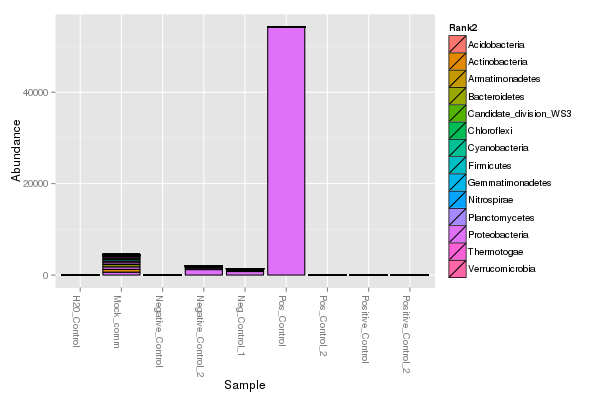

In [11]:
%%R -w 600 -h 400
plot_bar(Controls, fill = 'Rank2', x = "Sample")

In [12]:
%%R
Control = subset_samples(physeq, X.sample %in% c("Neg_Control_1", "Negative_Control_2"))

In [13]:
%%R
Mock = subset_samples(physeq, X.sample == "Mock_comm")
Mock = prune_taxa(taxa_sums(Mock) > 0, Mock)

Pos = subset_samples(physeq, X.sample == "Pos_Control")
Pos = prune_taxa(taxa_sums(Pos) > 0, Pos)
tax_table(Pos)
unique(tax_table(Mock))

Taxonomy Table:     [36 taxa by 8 taxonomic ranks]:
          Rank1      Rank2             Rank3                  
OTU.409   "Bacteria" "Acidobacteria"   "Holophagae"           
OTU.1116  "Bacteria" "Verrucomicrobia" "Verrucomicrobiae"     
OTU.2936  "Bacteria" "Acidobacteria"   "Acidobacteriales"     
OTU.2132  "Bacteria" "Bacteroidetes"   "Sphingobacteriia"     
OTU.4013  "Bacteria" "Bacteroidetes"   "Flavobacteria"        
OTU.653   "Bacteria" "Bacteroidetes"   "Flavobacteria"        
OTU.6162  "Bacteria" "Acidobacteria"   "DA023"                
OTU.5957  "Bacteria" "Firmicutes"      "Bacilli"              
OTU.8456  "Bacteria" "Firmicutes"      "Bacilli"              
OTU.7459  "Bacteria" "Firmicutes"      "Bacilli"              
OTU.4596  "Bacteria" "Firmicutes"      "Bacilli"              
OTU.121   "Bacteria" "Firmicutes"      "Bacilli"              
OTU.8113  "Bacteria" "Firmicutes"      "Bacilli"              
OTU.8342  "Bacteria" "Firmicutes"      "Bacilli"              
OTU

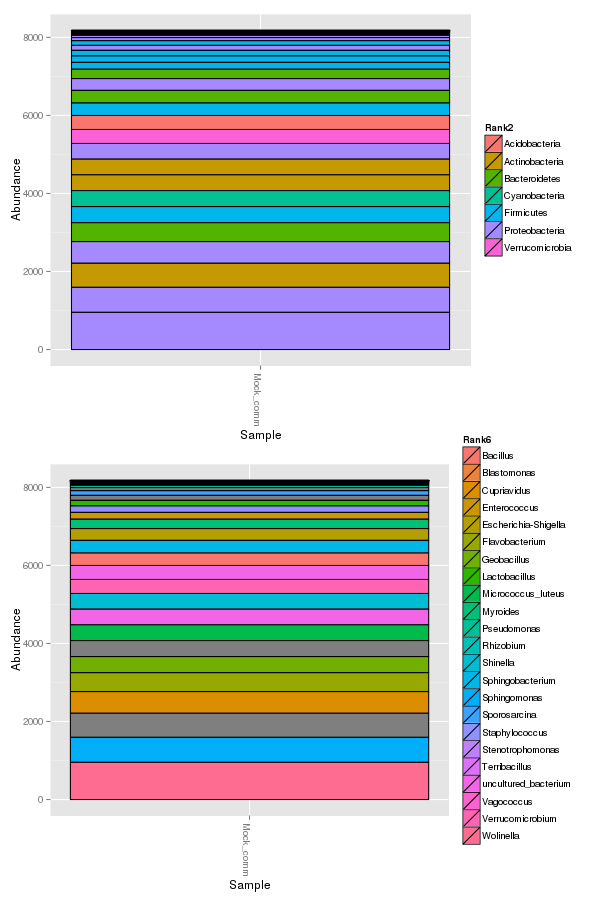

In [14]:
%%R -w 600 -h 900
p1 = plot_bar(Mock, fill = 'Rank2', x = "Sample")

p2 = plot_bar(Mock, fill = 'Rank6', x = "Sample")

grid.arrange(p1, p2, ncol=1)

# Comparing mock community OTU composition to table of 'true' mock community composition

In [15]:
%%R -i mockCommDir
setwd(mockCommDir)

mock.known = read.delim('strain_taxonomy.txt', sep='\t')

mock.known = mock.known$phylum %>% table %>% as.data.frame
colnames(mock.known) = c('phylum', 'freq.known')

mock.known = mock.known %>%
    group_by() %>%
    mutate(freq.known.norm = freq.known / sum(freq.known))

mock.known %>% head

Source: local data frame [5 x 3]

          phylum freq.known freq.known.norm
          (fctr)      (int)           (dbl)
1 Actinobacteria          4      0.10526316
2  Bacteroidetes          2      0.05263158
3     Firmicutes          8      0.21052632
4 Proteobacteria         23      0.60526316
5   Spirochaetes          1      0.02631579


## Comparing relative compositions of phylum

In [16]:
%%R

Mock.snorm = transform_sample_counts(Mock, function(x) x/sum(x))

tbl.otu = Mock.snorm %>% otu_table %>% as.data.frame
tbl.otu$otu = rownames(tbl.otu)

tbl.otu = tbl.otu %>%
    gather('sample', 'abundance', 1:(ncol(tbl.otu)-1)) %>%
    group_by(otu) %>%
    mutate(total_abund = sum(abundance))

tbl.otu

Source: local data frame [43 x 4]
Groups: otu [43]

        otu    sample    abundance  total_abund
      (chr)    (fctr)        (dbl)        (dbl)
1   OTU.409 Mock_comm 0.0001222344 0.0001222344
2  OTU.1116 Mock_comm 0.0438821660 0.0438821660
3  OTU.2936 Mock_comm 0.0438821660 0.0438821660
4  OTU.2132 Mock_comm 0.0393594915 0.0393594915
5  OTU.4013 Mock_comm 0.0299474392 0.0299474392
6   OTU.653 Mock_comm 0.0001222344 0.0001222344
7  OTU.9530 Mock_comm 0.0592837061 0.0592837061
8  OTU.6162 Mock_comm 0.0001222344 0.0001222344
9  OTU.5957 Mock_comm 0.0210243247 0.0210243247
10 OTU.8456 Mock_comm 0.0173572913 0.0173572913
..      ...       ...          ...          ...


In [17]:
%%R
tbl.tax = Mock.snorm %>% tax_table %>% as.data.frame
tbl.tax$otu = rownames(tbl.tax)

tbl.j = inner_join(tbl.otu, tbl.tax, c('otu' = 'otu'))
tbl.j %>% head(n=3)

Source: local data frame [3 x 12]
Groups: otu [3]

       otu    sample    abundance  total_abund    Rank1           Rank2
     (chr)    (fctr)        (dbl)        (dbl)   (fctr)          (fctr)
1  OTU.409 Mock_comm 0.0001222344 0.0001222344 Bacteria   Acidobacteria
2 OTU.1116 Mock_comm 0.0438821660 0.0438821660 Bacteria Verrucomicrobia
3 OTU.2936 Mock_comm 0.0438821660 0.0438821660 Bacteria   Acidobacteria
Variables not shown: Rank3 (fctr), Rank4 (fctr), Rank5 (fctr), Rank6 (fctr),
  Rank7 (fctr), Rank8 (fctr)


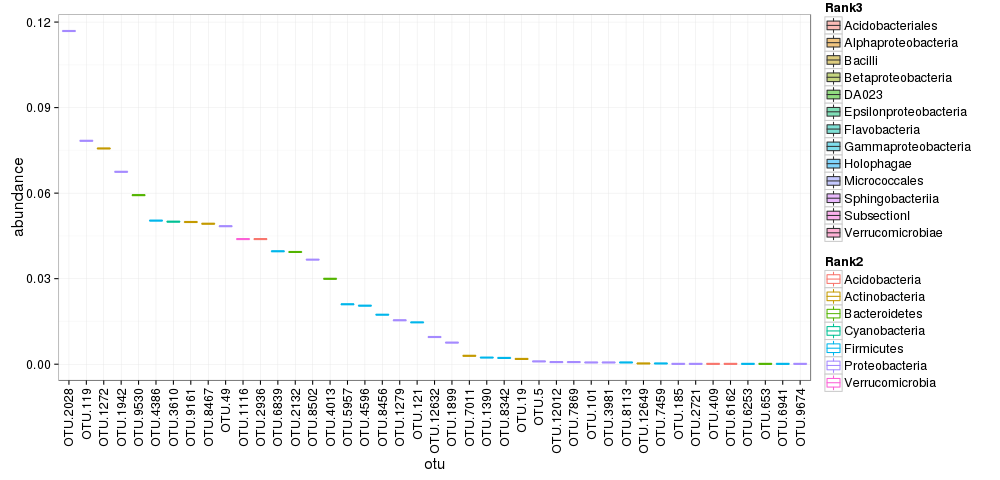

In [18]:
%%R -w 1000 

tbl.j$otu = reorder(tbl.j$otu, -tbl.j$total_abund)

ggplot(tbl.j, aes(otu, abundance, color=Rank2, fill=Rank3)) +
    geom_boxplot(alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

In [19]:
%%R 
# mock communities from sequence data

tmp = tbl.j %>% 
    group_by(otu, Rank2) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    select(Rank2) 

mock.est = tmp$Rank2 %>% table %>% as.data.frame
colnames(mock.est) = c('phylum', 'freq.est')

mock.est = mock.est %>%
    group_by() %>%
    mutate(freq.est.norm = freq.est / sum(freq.est))

mock.est 

Source: local data frame [7 x 3]

           phylum freq.est freq.est.norm
           (fctr)    (int)         (dbl)
1   Acidobacteria        3    0.06976744
2  Actinobacteria        6    0.13953488
3   Bacteroidetes        4    0.09302326
4   Cyanobacteria        1    0.02325581
5      Firmicutes       12    0.27906977
6  Proteobacteria       16    0.37209302
7 Verrucomicrobia        1    0.02325581


In [20]:
%%R

mock.j = full_join(mock.est, mock.known, c('phylum' = 'phylum')) %>%
    gather('variable', 'value', freq.est.norm, freq.known.norm) 

mock.j

Source: local data frame [16 x 5]

            phylum freq.est freq.known        variable      value
             (chr)    (int)      (int)          (fctr)      (dbl)
1    Acidobacteria        3         NA   freq.est.norm 0.06976744
2   Actinobacteria        6          4   freq.est.norm 0.13953488
3    Bacteroidetes        4          2   freq.est.norm 0.09302326
4    Cyanobacteria        1         NA   freq.est.norm 0.02325581
5       Firmicutes       12          8   freq.est.norm 0.27906977
6   Proteobacteria       16         23   freq.est.norm 0.37209302
7  Verrucomicrobia        1         NA   freq.est.norm 0.02325581
8     Spirochaetes       NA          1   freq.est.norm         NA
9    Acidobacteria        3         NA freq.known.norm         NA
10  Actinobacteria        6          4 freq.known.norm 0.10526316
11   Bacteroidetes        4          2 freq.known.norm 0.05263158
12   Cyanobacteria        1         NA freq.known.norm         NA
13      Firmicutes       12          8 fr

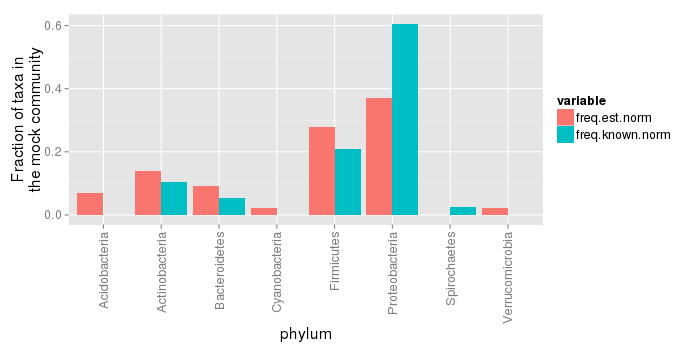

In [21]:
%%R -w 700 -h 350

ggplot(mock.j, aes(phylum, value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Fraction of taxa in\nthe mock community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

### Filtering out low abundance taxa

In [22]:
%%R 
# mock communities from sequence data

tmp = tbl.j %>% 
    filter(abundance > 0.01) %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(otu, Rank2) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    select(Rank2) 

mock.est = tmp$Rank2 %>% table %>% as.data.frame
colnames(mock.est) = c('phylum', 'freq.est')

mock.est = mock.est %>%
    group_by() %>%
    mutate(freq.est.norm = freq.est / sum(freq.est))

mock.est 

Source: local data frame [7 x 3]

           phylum freq.est freq.est.norm
           (fctr)    (int)         (dbl)
1   Acidobacteria        1    0.04761905
2  Actinobacteria        3    0.14285714
3   Bacteroidetes        3    0.14285714
4   Cyanobacteria        1    0.04761905
5      Firmicutes        6    0.28571429
6  Proteobacteria        6    0.28571429
7 Verrucomicrobia        1    0.04761905


In [23]:
%%R

mock.j = left_join(mock.est, mock.known, c('phylum' = 'phylum')) %>%
    gather('variable', 'value', freq.est.norm, freq.known.norm)

mock.j %>% head

Source: local data frame [6 x 5]

          phylum freq.est freq.known      variable      value
           (chr)    (int)      (int)        (fctr)      (dbl)
1  Acidobacteria        1         NA freq.est.norm 0.04761905
2 Actinobacteria        3          4 freq.est.norm 0.14285714
3  Bacteroidetes        3          2 freq.est.norm 0.14285714
4  Cyanobacteria        1         NA freq.est.norm 0.04761905
5     Firmicutes        6          8 freq.est.norm 0.28571429
6 Proteobacteria        6         23 freq.est.norm 0.28571429


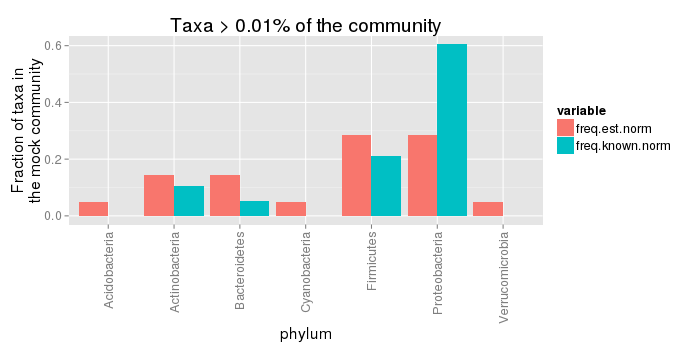

In [24]:
%%R -w 700 -h 350

ggplot(mock.j, aes(phylum, value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Fraction of taxa in\nthe mock community', title='Taxa > 0.01% of the community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

## Comparing relative compositions of 

In [25]:
%%R -i mockCommDir
setwd(mockCommDir)

mock.known = read.delim('strain_taxonomy.txt', sep='\t')

mock.known = mock.known$genus %>% table %>% as.data.frame
colnames(mock.known) = c('genus', 'freq.known')

mock.known = mock.known %>%
    group_by() %>%
    mutate(freq.known.norm = freq.known / sum(freq.known))

mock.known %>% head

Source: local data frame [6 x 3]

          genus freq.known freq.known.norm
         (fctr)      (int)           (dbl)
1 Achromobacter          1      0.02631579
2 Agrobacterium          1      0.02631579
3   Alcaligenes          2      0.05263158
4  Arthrobacter          1      0.02631579
5      Bacillus          2      0.05263158
6  Enterobacter          1      0.02631579


In [26]:
%%R 
# mock communities from sequence data

tmp = tbl.j %>% 
    mutate(Rank6 = gsub('^__', '', Rank6), 
           Rank6 = gsub('uncultured_', '', Rank6)) %>%
    group_by(otu, Rank6) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    select(Rank6) 

mock.est = tmp$Rank6 %>% table %>% as.data.frame
colnames(mock.est) = c('genus', 'freq.est')

mock.est = mock.est %>%
    group_by() %>%
    mutate(freq.est.norm = freq.est / sum(freq.est))

mock.est %>% head

Source: local data frame [6 x 3]

                 genus freq.est freq.est.norm
                (fctr)    (int)         (dbl)
1             Bacillus        4       0.12500
2            bacterium        3       0.09375
3          Blastomonas        1       0.03125
4          Cupriavidus        1       0.03125
5         Enterococcus        1       0.03125
6 Escherichia-Shigella        1       0.03125


In [27]:
%%R

mock.j = full_join(mock.est, mock.known, c('genus' = 'genus')) %>%
    gather('variable', 'value', freq.est.norm, freq.known.norm) %>%
    group_by(variable)

mock.j %>% head

Source: local data frame [6 x 5]
Groups: variable [1]

                 genus freq.est freq.known      variable   value
                 (chr)    (int)      (int)        (fctr)   (dbl)
1             Bacillus        4          2 freq.est.norm 0.12500
2            bacterium        3         NA freq.est.norm 0.09375
3          Blastomonas        1         NA freq.est.norm 0.03125
4          Cupriavidus        1         NA freq.est.norm 0.03125
5         Enterococcus        1          1 freq.est.norm 0.03125
6 Escherichia-Shigella        1         NA freq.est.norm 0.03125


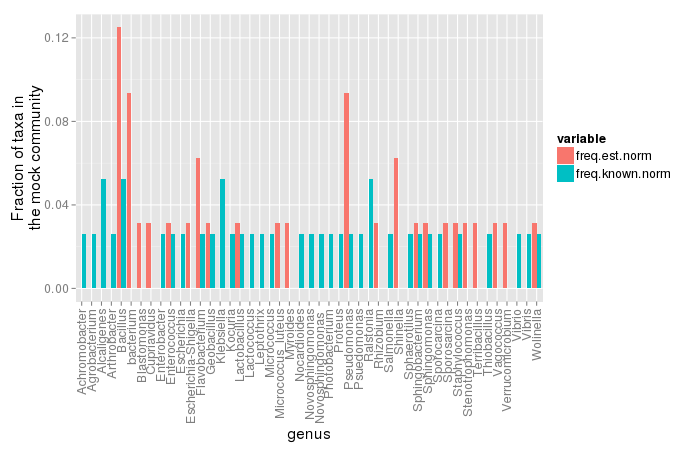

In [28]:
%%R -w 700 -h 450

ggplot(mock.j, aes(genus, value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Fraction of taxa in\nthe mock community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

### Conclusions

* The number of OTUs in the sequenced mock is pretty similar to the actual number of taxa in the community
  * 43 estimated compared to 39 actual
* The community composition between sequenced and true communities is:
  * Similar at the phylum level
  * Not too accurate at the genus level

## Identify taxa in negative controls

In [29]:
%%R
Control = subset_samples(physeq, X.sample %in% c("Neg_Control_1", "Negative_Control_2"))
Control = prune_taxa(taxa_sums(Control) > 0, Control)

In [32]:
%%R
?plot_bar

R Help on ‘plot_bar’plot_bar               package:phyloseq                R Documentation

_A _f_l_e_x_i_b_l_e, _i_n_f_o_r_m_a_t_i_v_e _b_a_r_p_l_o_t _p_h_y_l_o_s_e_q _d_a_t_a

_D_e_s_c_r_i_p_t_i_o_n:

     There are many useful examples of phyloseq barplot graphics in the
     phyloseq online tutorials. This function wraps ‘ggplot2’ plotting,
     and returns a ‘ggplot2’ graphic object that can be saved or
     further modified with additional layers, options, etc. The main
     purpose of this function is to quickly and easily create
     informative summary graphics of the differences in taxa abundance
     between samples in an experiment.

_U_s_a_g_e:

       plot_bar(physeq, x="Sample", y="Abundance", fill=NULL,
       title=NULL, facet_grid=NULL)
     
_A_r_g_u_m_e_n_t_s:

  physeq: (Required). An ‘otu_table-class’ or ‘phyloseq-class’.

       x: (Optional). Optional, but recommended, especially if your
          d

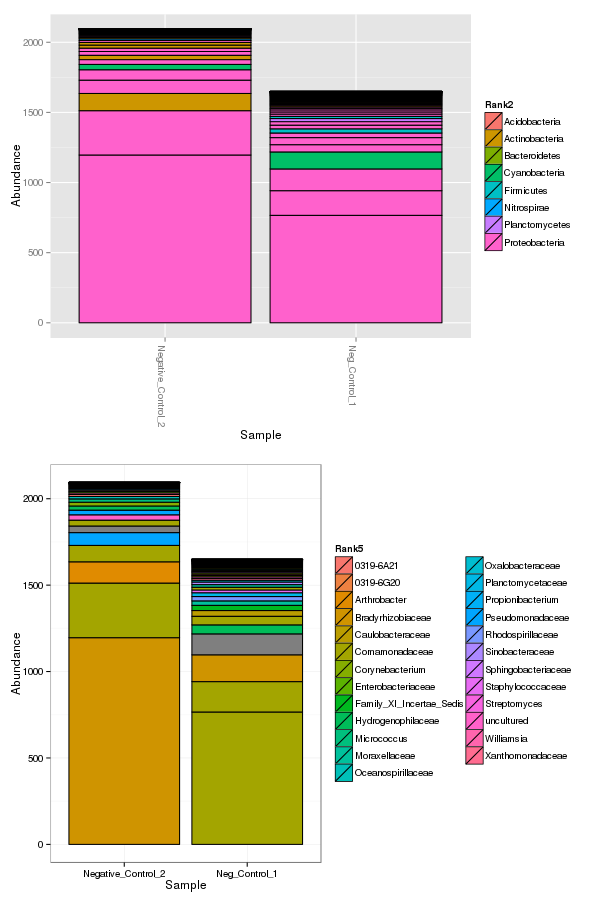

In [33]:
%%R -w 600 -h 900

p1 = plot_bar(Control, fill = 'Rank2', x = "Sample")

p2 = plot_bar(Control, fill = 'Rank5', x = "Sample") +
        theme_bw() +
        theme(plot.title = element_text(face="bold", size=20)) +
        guides(fill=guide_legend(ncol=2))

grid.arrange(p1, p2, ncol=1)

In [36]:
%%R
pdf(file = "/home/bryan/RhizCG/figures/diagnostics/NegControl.pdf", height = 8, width = 6)
grid.arrange(p1, p2, ncol=1)
dev.off()

png 
  2 
